# Ensemble Model

In [1]:
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

C:\Users\Friend\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Friend\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Load and Sample data

In [3]:
#Data here used is preprocessed(deduplication,removal of html tags,punctuation,stop words,stemming)
con =sqlite3.connect(r'C:\Users\Friend\AI\AI_datasets\Amazon\cleaned_database.sqlite')
filtered_data  = pd.read_sql_query('SELECT * FROM Reviews WHERE Score != 3',con)
filtered_data = filtered_data.drop('index',axis = 1)
filtered_data['Score'] = filtered_data['Score'].map(lambda x: 1 if x == 'positive' else 0)
filtered_data = filtered_data.sort_values('Time')

In [4]:
data = filtered_data.head(100000)
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'CleanedText'],
      dtype='object')

In [5]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data['CleanedText'], data['Score'], test_size=0.3, random_state=0)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(70000,) (70000,) (30000,) (30000,)


# Featurization

*  BOW

In [6]:
# Performing BOW on review
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
vocabulary = count_vect.fit(X_train)

In [7]:
bag_of_words_train = count_vect.transform(X_train)
print(bag_of_words_train.shape)

(70000, 31572)


In [8]:
bag_of_words_test = count_vect.transform(X_test)
print(bag_of_words_test.shape)

(30000, 31572)


* tfidf

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
vocabulary = tf_idf_vect.fit(X_train)

In [42]:
tf_idf_train = tf_idf_vect.transform(X_train)
print(tf_idf_train.shape)

(70000, 932590)


In [43]:
tf_idf_test = tf_idf_vect.transform(X_test)
print(tf_idf_test.shape)

(30000, 932590)


* avgword2vec

In [49]:
from gensim.models import Word2Vec

list_of_sent=[]
for sent in X_train:
    list_of_sent.append(sent.split())

#word2vec
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

#Average word2vec
sent_vectors_train = []; 
for sent in list_of_sent: 
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)

C:\Users\Friend\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [54]:
from gensim.models import Word2Vec

i=0
list_of_sent=[]
for sent in X_test:
    list_of_sent.append(sent.split())

#Average word2vec
sent_vectors_test = []; 
for sent in list_of_sent: 
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)

* tfidf weighted word2vec

In [57]:
cons = sqlite3.connect(r'C:\Users\Friend\AI\AI_datasets\Amazon\featurizations.sqlite')
cursor = cons.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('Reviews',), ('check',), ('df',), ('tfidfword2vec_train',), ('tf_idf_test',)]


In [58]:
cons =sqlite3.connect(r'C:\Users\Friend\AI\AI_datasets\Amazon\featurizations.sqlite')
tfidf_sent_vectors_train  = pd.read_sql_query('SELECT * FROM tfidfword2vec_train',cons)
tfidf_sent_vectors_train = tfidf_sent_vectors_train.drop('index',axis = 1)
tfidf_sent_vectors_train.shape

(70000, 50)

In [59]:
cons =sqlite3.connect(r'C:\Users\Friend\AI\AI_datasets\Amazon\featurizations.sqlite')
tfidf_sent_vectors_test  = pd.read_sql_query('SELECT * FROM tf_idf_test',cons)
tfidf_sent_vectors_test = tfidf_sent_vectors_test.drop('index',axis = 1)
tfidf_sent_vectors_test.shape

(30000, 50)

# Random Forest

In [14]:
grid_hyperparameter = [{'n_estimators'  : [100, 200, 500, 1000, 2000],'max_depth':[5,10]}]
grid_hyperparameter

[{'n_estimators': [100, 200, 500, 1000, 2000], 'max_depth': [5, 10]}]

* BOW

In [13]:
clf = GridSearchCV(RandomForestClassifier(class_weight = 'balanced',criterion='gini'), grid_hyperparameter, scoring = 'f1', cv=2)
clf.fit(bag_of_words_train, y_train)

clf_n = clf.best_estimator_.get_params()['n_estimators']
clf_depth = clf.best_estimator_.get_params()['max_depth']

print(clf_n)
print(clf_depth)

1000
10


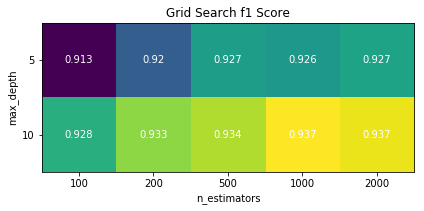

In [25]:
n_estimators = grid_hyperparameter[0]['n_estimators']
max_depth = grid_hyperparameter[0]['max_depth']
df = pd.DataFrame(clf.grid_scores_)
scores = np.array(df['mean_validation_score']).reshape(2,5)
fig, ax = plt.subplots()
plt.imshow(scores, interpolation='nearest')
plt.colorbar()
for i in range(len(max_depth)):
    for j in range(len(n_estimators)):
        text = ax.text(j, i, np.round(scores[i, j],3),
                       ha="center", va="center", color="w")
ax.set_xticks(np.arange(len(n_estimators)))
ax.set_yticks(np.arange(len(max_depth)))
ax.set_xticklabels(n_estimators)
ax.set_yticklabels(max_depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
ax.set_title("Grid Search f1 Score")
fig.tight_layout()
plt.show()

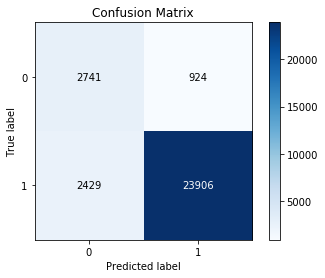

In [28]:
clf = RandomForestClassifier(class_weight = 'balanced',n_estimators=1000, criterion='gini', max_depth=10, random_state=42, n_jobs=-1)
clf.fit(bag_of_words_train, y_train)

pred = clf.predict(bag_of_words_test)
skplt.metrics.plot_confusion_matrix(y_test, pred, normalize=False)

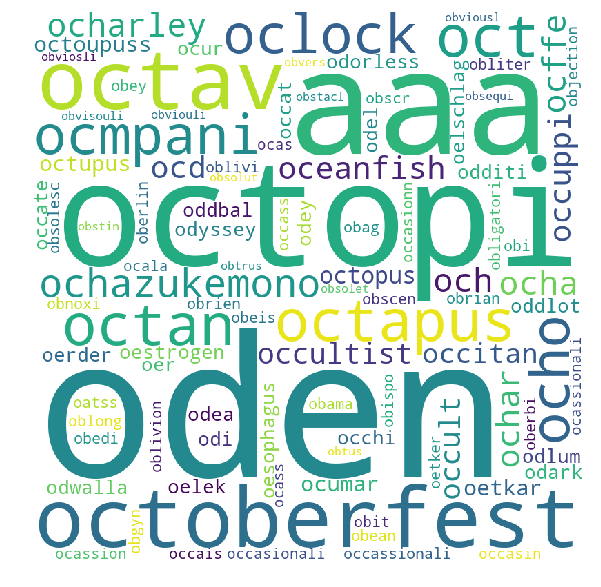

In [40]:
indices = np.argsort(clf.feature_importances_)

indices = np.argsort(clf.feature_importances_)
feature_importance = [np.take(count_vect.get_feature_names(),index)  for index in indices[0:100]]

from wordcloud import WordCloud

featurez=(" ").join(feature_importance)
wordcloud = WordCloud(width = 800, height = 800,background_color ='white',min_font_size = 10).generate(featurez) 
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

* tfidf

In [45]:
clf = GridSearchCV(RandomForestClassifier(class_weight = 'balanced',criterion='gini'), grid_hyperparameter, scoring = 'f1', cv=2)
clf.fit(tf_idf_train, y_train)

clf_n = clf.best_estimator_.get_params()['n_estimators']
clf_depth = clf.best_estimator_.get_params()['max_depth']

print(clf_n)
print(clf_depth)

2000
10


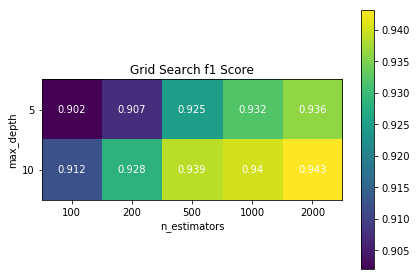

In [46]:
n_estimators = grid_hyperparameter[0]['n_estimators']
max_depth = grid_hyperparameter[0]['max_depth']
df = pd.DataFrame(clf.grid_scores_)
scores = np.array(df['mean_validation_score']).reshape(2,5)
fig, ax = plt.subplots()
plt.imshow(scores, interpolation='nearest')
plt.colorbar()
for i in range(len(max_depth)):
    for j in range(len(n_estimators)):
        text = ax.text(j, i, np.round(scores[i, j],3),
                       ha="center", va="center", color="w")
ax.set_xticks(np.arange(len(n_estimators)))
ax.set_yticks(np.arange(len(max_depth)))
ax.set_xticklabels(n_estimators)
ax.set_yticklabels(max_depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
ax.set_title("Grid Search f1 Score")
fig.tight_layout()
plt.show()

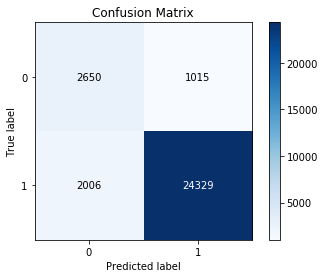

In [47]:
clf = RandomForestClassifier(class_weight = 'balanced',n_estimators=clf_n, criterion='gini', max_depth=clf_depth, random_state=42, n_jobs=-1)
clf.fit(tf_idf_train, y_train)

pred = clf.predict(tf_idf_test)
skplt.metrics.plot_confusion_matrix(y_test, pred, normalize=False)

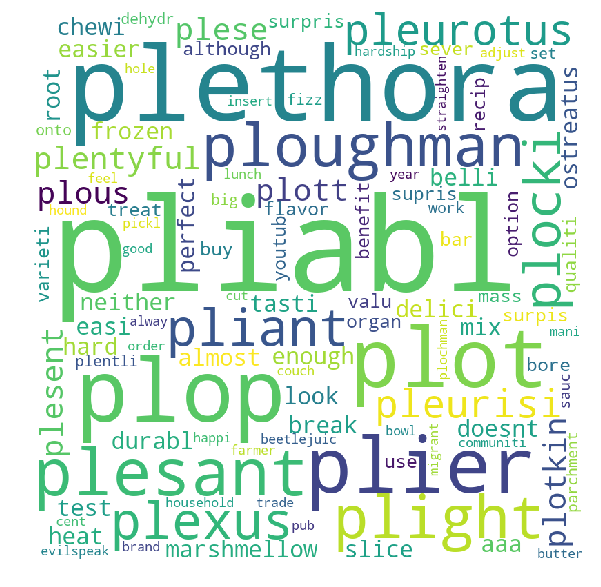

In [50]:
indices = np.argsort(clf.feature_importances_)

indices = np.argsort(clf.feature_importances_)
feature_importance = [np.take(tf_idf_vect.get_feature_names(),index)  for index in indices[0:100]]

from wordcloud import WordCloud

featurez=(" ").join(feature_importance)
wordcloud = WordCloud(width = 800, height = 800,background_color ='white',min_font_size = 10).generate(featurez) 
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

* avgword2vec

In [51]:
clf = GridSearchCV(RandomForestClassifier(class_weight = 'balanced'), grid_hyperparameter, scoring = 'f1', cv=2)
clf.fit(sent_vectors_train, y_train)


clf_n = clf.best_estimator_.get_params()['n_estimators']
clf_depth = clf.best_estimator_.get_params()['max_depth']

print(clf_n)
print(clf_depth)

500
10


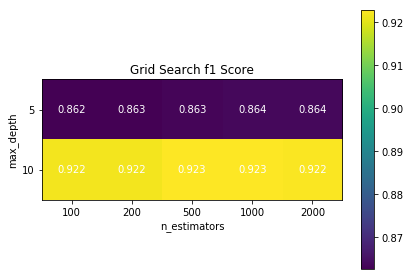

In [52]:
n_estimators = grid_hyperparameter[0]['n_estimators']
max_depth = grid_hyperparameter[0]['max_depth']
df = pd.DataFrame(clf.grid_scores_)
scores = np.array(df['mean_validation_score']).reshape(2,5)
fig, ax = plt.subplots()
plt.imshow(scores, interpolation='nearest')
plt.colorbar()
for i in range(len(max_depth)):
    for j in range(len(n_estimators)):
        text = ax.text(j, i, np.round(scores[i, j],3),
                       ha="center", va="center", color="w")
ax.set_xticks(np.arange(len(n_estimators)))
ax.set_yticks(np.arange(len(max_depth)))
ax.set_xticklabels(n_estimators)
ax.set_yticklabels(max_depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
ax.set_title("Grid Search f1 Score")
fig.tight_layout()
plt.show()

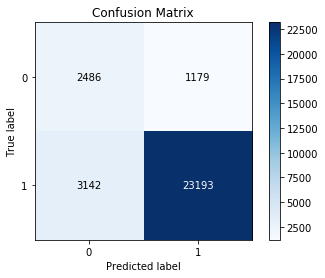

In [56]:
clf = RandomForestClassifier(class_weight = 'balanced',n_estimators=clf_n, criterion='gini', max_depth=clf_depth, random_state=42, n_jobs=-1)
clf.fit(sent_vectors_train, y_train)

pred = clf.predict(sent_vectors_test)
skplt.metrics.plot_confusion_matrix(y_test, pred, normalize=False)

* tfidf weighted word2vec

In [60]:
#train model
clf = GridSearchCV(RandomForestClassifier(class_weight = 'balanced'), grid_hyperparameter, scoring = 'f1', cv=2)
clf.fit(tfidf_sent_vectors_train, y_train)

clf_n = clf.best_estimator_.get_params()['n_estimators']
clf_depth = clf.best_estimator_.get_params()['max_depth']

print(clf_n)
print(clf_depth)

1000
10


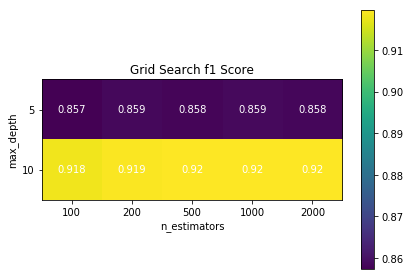

In [61]:
n_estimators = grid_hyperparameter[0]['n_estimators']
max_depth = grid_hyperparameter[0]['max_depth']
df = pd.DataFrame(clf.grid_scores_)
scores = np.array(df['mean_validation_score']).reshape(2,5)
fig, ax = plt.subplots()
plt.imshow(scores, interpolation='nearest')
plt.colorbar()
for i in range(len(max_depth)):
    for j in range(len(n_estimators)):
        text = ax.text(j, i, np.round(scores[i, j],3),
                       ha="center", va="center", color="w")
ax.set_xticks(np.arange(len(n_estimators)))
ax.set_yticks(np.arange(len(max_depth)))
ax.set_xticklabels(n_estimators)
ax.set_yticklabels(max_depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
ax.set_title("Grid Search f1 Score")
fig.tight_layout()
plt.show()

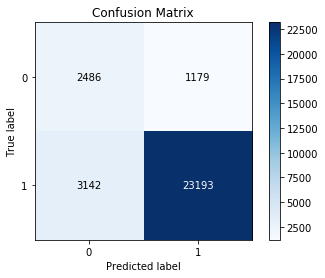

In [56]:
clf = RandomForestClassifier(class_weight = 'balanced',n_estimators=clf_n, criterion='gini', max_depth=clf_depth, random_state=42, n_jobs=-1)
clf.fit(tfidf_sent_vectors_train, y_train)

pred = clf.predict(sent_vectors_test)
skplt.metrics.plot_confusion_matrix(y_test, pred, normalize=False)

# Light Gradient Boosting decision tree

In [9]:
grid_parameter = [{'num_leaves': [20,40,60,80],'min_data_in_leaf': [30, 50, 100, 300, 400],'max_depth':[4,6,8,10,12]}]
grid_parameter

[{'num_leaves': [20, 40, 60, 80],
  'min_data_in_leaf': [30, 50, 100, 300, 400],
  'max_depth': [4, 6, 8, 10, 12]}]

In [ ]:
clf_boost = GridSearchCV(lgb.LGBMClassifier(),grid_parameter, cv=3)
clf_boost.fit(sent_vectors_train, y_train)

C:\Users\Friend\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Friend\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Friend\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


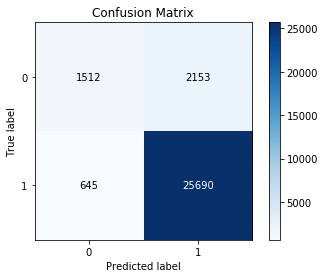

In [13]:
#f1 score
clf_boost_f1_train = clf_boost.score(sent_vectors_train, y_train)
clf_boost_f1_test = clf_boost.score(sent_vectors_test, y_test)

#predict values
pred = clf_boost.predict(sent_vectors_test)
skplt.metrics.plot_confusion_matrix(y_test, pred, normalize=False)

In [11]:
clf_boost_n = clf_boost.best_estimator_.get_params()['num_leaves']
clf_boost_l = clf_boost.best_estimator_.get_params()['min_data_in_leaf']
clf_boost_d = clf_boost.best_estimator_.get_params()['max_depth']

In [12]:
print(clf_boost_n)
print(clf_boost_l)
print(clf_boost_d)

80
300
12


In [14]:
print(clf_boost_f1_train)
print(clf_boost_f1_test)

0.9432428571428572
0.9067333333333333
